# k-Nearest Neighbour (kNN) classifier for breast ultrasounds

Broadly, the classifier works in two stages
- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples

To get a good value of k multi fold cross-validation will be used

In [4]:
# some setup code for this notebook
import numpy as np
import matplotlib.pyplot as plt
from functions import data
from functions import k_nearest_neighbor

# This makes matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook reload external python modules;
%load_ext autoreload
%autoreload 2

## The ultra sound scan data
- 163 scans total, clinically confirmed as having either bening or malignant (cancerous) lesions 
- 100 scans for training, 63 for testing
- Training data was passed through 7 transformations to give us 800 training images total
- Testing images not transformed
- Both training and testing images were resized to 360X528
- Raw pngs then converted to numpy arrays and saved

In [5]:
#  load the data, code for the data function is in the data.py file
X_train, y_train, X_test, y_test = data.getData()

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

(800, 224, 224, 3)
(800, 1)
(63, 224, 224, 3)
(63, 1)
Training data shape:  (800, 224, 224, 3)
Training labels shape:  (800, 1)
Test data shape:  (63, 224, 224, 3)
Test labels shape:  (63, 1)


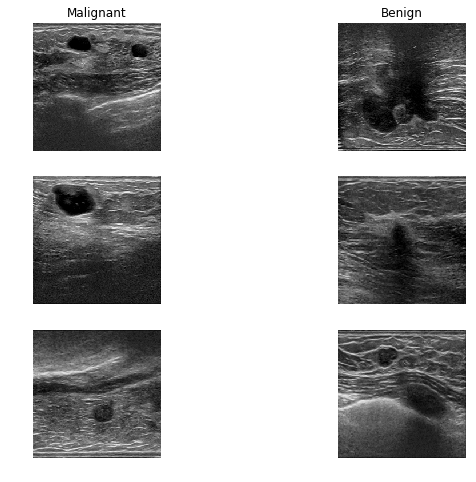

In [6]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = [1, 0]
num_classes = len(classes)
samples_per_class = 3
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            if cls == 1: title = 'Malignant'
            else: title = 'Benign'
            plt.title(title)
plt.show()

In [7]:
# Subsample the training data for faster code execution in this demo
num_training = 800
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 63

In [8]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(800, 150528) (63, 150528)


In [9]:
# instantiate classifier and train it
# once again, training simply memorizes data
classifier = k_nearest_neighbor.KNearestNeighbor()
classifier.train(X_train, y_train)

Classification involves computing distances between a test image and the memorized training images. The classifier compares the test image to all training images and transfers the label of the k most similar training examples.

In [10]:
# Compute distances (vectorized)
dists = classifier.compute_distances_no_loops(X_test)
print(dists.shape)

(63, 800)


We now use k = 5

In [22]:
# print(y_train[88])
y_test_pred = classifier.predict_labels(dists, k=1)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

TypeError: unhashable type: 'numpy.ndarray'

### Cross-validation

So far we set the value k arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [12]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
#                                                                              
# We Split up the training data into folds. After splitting, X_train_folds and    
# y_train_folds are lists of length num_folds, where                
# y_train_folds[i] is the label vector for the points in X_train_folds[i]     
# We use the numpy array_split function                               
################################################################################

X_train_folds = np.split(X_train, num_folds)
y_train_folds = np.split(y_train, num_folds)

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}
num_split = X_train.shape[0] / num_folds
acc_k = np.zeros((len(k_choices), num_folds), dtype=np.float)

################################################################################
#                                                                              
# Perform k-fold cross validation to find the best value of k. For each        
# possible value of k, we run the k-nearest-neighbor algorithm num_folds times,   
# where in each case you use all but one of the folds as training data and the 
# last fold as a validation set. Store the accuracies for all fold and all     
# values of k in the k_to_accuracies dictionary.                               
################################################################################

for ik ,k in enumerate(k_choices):
    for i in range(num_folds):
        train_set = np.concatenate((X_train_folds[:i]+X_train_folds[i+1:]))
        label_set = np.concatenate((y_train_folds[:i]+y_train_folds[i+1:]))
        classifier.train(train_set, label_set)
        y_pred_fold = classifier.predict(X_train_folds[i], k=k, num_loops=0)
        num_correct = np.sum(y_pred_fold == y_train_folds[i])
        acc_k[ik, i] = float(num_correct) / num_split
    k_to_accuracies[k] = acc_k[ik]

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

TypeError: unhashable type: 'numpy.ndarray'

In [ ]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [ ]:
# Based on the cross-validation results above, the best value for k seems to be 3,   
# We now retrain the classifier using all the training data, and test it on the test
# data.
best_k = 3

classifier = k_nearest_neighbor.KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))